# Heart Disease Prediction Model

## I. Project Description
Heart disease is one of the leading causes of death for most people in the United States, and about half of Americans have at least one of three key risk factors for heart disease. Because of the prevalence of heart disease, I decided to build a model to predict heart disease based on some of the most common and influential predictors. This model could predict whether an individual has heart disease so they can receive the necessary treatment to reduce the burden of their condition.

This data set has around <b>319,800 rows</b> and <b>18 variables</b>: 9 boolean, 5 string, and 4 decimal.
<ul>
    <li>The booleans include the presence of heart disease, smoking, heavy drinking, stroke, skin cancer, asthma, diabetes, and kidney cancer.</li>
    <li>The strings include sex, race, and general health.</li>
    <li>The decimals include sleep time, bad physical health days in a month, and bad mental health days in a month.</li>
</ul>

From the data, the dependent variable (y) we are trying to predict is `HeartDisease`, and the rest are feature variables.

## II. Data Analysis
### A. Project Functions
I will use below modules to support my model development:
<ul>
    <li><b>numpy</b>, <b>pandas</b>, and <b>copy</b>: to handle data cleaning and calculation</li>
    <li><b>matplotlib</b>: to graph data</li>
    <li><b>sklearn</b>: to run classification models</li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import mixture

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, RocCurveDisplay, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import export_text

import warnings
warnings. filterwarnings('ignore')

### B. Loading Data
The dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease?resource=download): `heart_2020_cleaned.csv`

In [2]:
df = pd.read_csv("heart_2020_cleaned.csv")
df.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No


### C. Cleaning Data
#### 1. Check NA Values
No NA values was found.

In [3]:
df.isna().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

#### 2. Check all unique values of each variable
Doing so gives us a sense of necessary data conversion needed.
By checking unique values of each variable, we can see that:
<ul>
    <li>Diabetic has 2 abnormal values (not Yes and No)</li>
    <li>AgeCategory, Race, and GenHealth have multiple categorical values</li>
</ul>

In [4]:
for col in df:
    print(f'{col}: {df[col].unique()}')

HeartDisease: ['No' 'Yes']
BMI: [16.6  20.34 26.58 ... 62.42 51.46 46.56]
Smoking: ['Yes' 'No']
AlcoholDrinking: ['No' 'Yes']
Stroke: ['No' 'Yes']
PhysicalHealth: [ 3.  0. 20. 28.  6. 15.  5. 30.  7.  1.  2. 21.  4. 10. 14. 18.  8. 25.
 16. 29. 27. 17. 24. 12. 23. 26. 22. 19.  9. 13. 11.]
MentalHealth: [30.  0.  2.  5. 15.  8.  4.  3. 10. 14. 20.  1.  7. 24.  9. 28. 16. 12.
  6. 25. 17. 18. 21. 29. 22. 13. 23. 27. 26. 11. 19.]
DiffWalking: ['No' 'Yes']
Sex: ['Female' 'Male']
AgeCategory: ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
Race: ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Diabetic: ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
PhysicalActivity: ['Yes' 'No']
GenHealth: ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
SleepTime: [ 5.  7.  8.  6. 12.  4.  9. 10. 15.  3.  2.  1. 16. 18. 14. 20. 11. 13.
 17. 24. 19. 21. 22. 23.]
Asthma: ['Yes' 'No']
KidneyDisease: 

#### 3. Data Conversion
For the 11 binary variables, I replaced their binary values with 0’s and 1’s.<br>
There were three multi-categorical variables: `AgeCategory`, `GenHealth`, and `Race`. 
<ul>
    <li>The <b>Age</b> variable is binned by 5-year bins and is ordinal, so I de-binned them using an average of each bin's bottom and top ages to retain its characteristics.</li>
    <li>The <b>Race</b> variable is nominal, so I used one-hot encoding to handle it.</li>
    <li>The <b>General Health</b> variable has both ordinal and nominal characteristics and hence, is more complicated than the Age and Race. Scaling its values from 1 to 5 does not reflect well the relationship among five categorical values. For this reason, I used the weight of evidence (WOE) method to encode values of General Health.</li>
</ul>

##### 3.1 Let's encode binary variables

In [5]:
df.replace(('Yes', 'No'), (1,0), inplace=True)
df.replace(('Yes (during pregnancy)', 'No, borderline diabetes'), (1,0), inplace=True)
df.replace(('Male', 'Female'), (1,0), inplace=True)

##### 3.2 One-hot encoding `Race`

In [6]:
# Create a copy of original data frame
df_copy = copy.copy(df)

In [7]:
# One-hot encoding Race
df_copy = df_copy.join(pd.get_dummies(df_copy['Race'], drop_first=False)) #Keep all newly generated features for classification
df_copy = df_copy.drop(columns="Race")
df_copy.head(3)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,American Indian/Alaskan Native,Asian,Black,Hispanic,Other,White
0,0,16.60,1,0,0,3.0,30.0,0,0,55-59,...,5.0,1,0,1,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,80 or older,...,7.0,0,0,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,65-69,...,8.0,1,0,0,0,0,0,0,0,1


##### 3.2 WOE encoding `GenHealth`
Read more about WOE (Weight of Evidence) method [here](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02).<br>
<b>Step 1</b>: Let's calculate the probability of HeartDisease = 1 (Yes) for each category of GenHealth:

In [8]:
woe_df_copy = df_copy.groupby('GenHealth')['HeartDisease'].mean()
woe_df_copy = pd.DataFrame(woe_df_copy)
# Rename col name to HeartDisease_Yes
woe_df_copy = woe_df_copy.rename(columns = {'HeartDisease':'HeartDisease_Yes'})
woe_df_copy

,HeartDisease_Yes
GenHealth,
Excellent,0.022441
Fair,0.204285
Good,0.102632
Poor,0.341040
Very good,0.047261


<b>Step 2</b>: Let's calculate the probability of HeartDisease = 0:

In [9]:
woe_df_copy['HeartDisease_No'] = 1 - woe_df_copy.HeartDisease_Yes
woe_df_copy

,HeartDisease_Yes,HeartDisease_No
GenHealth,,
Excellent,0.022441,0.977559
Fair,0.204285,0.795715
Good,0.102632,0.897368
Poor,0.341040,0.658960
Very good,0.047261,0.952739


<b>Step 3</b>: Let's compute WoE

In [10]:
woe_df_copy['WOE'] = np.log(woe_df_copy.HeartDisease_Yes/woe_df_copy.HeartDisease_No)
woe_df_copy

,HeartDisease_Yes,HeartDisease_No,WOE
GenHealth,,,
Excellent,0.022441,0.977559,-3.774170
Fair,0.204285,0.795715,-1.359723
Good,0.102632,0.897368,-2.168318
Poor,0.341040,0.658960,-0.658663
Very good,0.047261,0.952739,-3.003664


<b>Step 4</b>: Map `GenHealth` values with their respective WOE values

In [11]:
df_copy.loc[:,'GenHealth_encoded'] = df_copy['GenHealth'].map(woe_df_copy['WOE'])
df_copy = df_copy.drop(columns="GenHealth")

##### 3.3 Encoding `AgeCategory`

In [12]:
new_ages = []
for age_group in df_copy["AgeCategory"]:
    low_age = int(age_group[:2]) # The 2 first characters
    if low_age == 80:
        new_ages.append(low_age)
    else:
        high_age = int(age_group[-2:]) # The 2 last characters
        mid_age = (low_age + high_age) / 2
        new_ages.append(mid_age)
        
# Adding new_ages to df_copy and remove AgeCategory
df_copy["UpdatedAges"] = new_ages
df_copy = df_copy.drop(columns="AgeCategory")

#### 4. Check correlation among feature variables
After encoding all variables, I found no significant correlations. Therefore, from the statistical point of view, we could keep all variables when modeling.

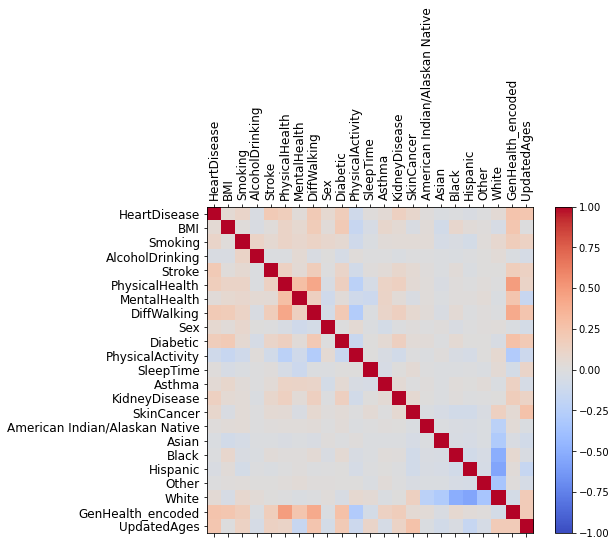

In [14]:
corr = df_copy.corr()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_copy.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90, fontsize=12, color = 'k')
plt.yticks(fontsize=12, color = 'k')
ax.set_yticks(ticks)
ax.set_xticklabels(df_copy.columns, color = 'k')
ax.set_yticklabels(df_copy.columns, color = 'k')
plt.show()

### D. Modeling 

Using encoded variables and splitting them into 80% training, 10% validation, and 10% testing sets with stratify = y, I then tried multiple models and the grid search method to find the models and parameters that performed the best. Since the label variable and majority of the feature variables are categorical/binary variables, I tried classification models only.

In [15]:
# retrieve the array of data
data = df_copy.values
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:] #all other variables
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

#### 1. Experimenting with Random Forest, Logistic Regression, and Decision Tree
<ul>
    <li><b>Logistic Regression</b> with C = 100 and max_tier = 5,000 produced the <b>highest accuracy of 0.917</b>.</li>
    <li><b>Decision Tree</b> with max_depth = [1, 3, None] gave a pretty close accuracy to Logistic Regression, but its <b>best parameter for max_depth was 1</b>, which was <b>not valuable</b> in classifying features.</li>
</ul>

In [16]:
classifiers = {0: (RandomForestClassifier()),
               1: (linear_model.LogisticRegression()),
               2: (DecisionTreeClassifier())}
parameters = {0: {'n_estimators': [5,10,100], 'random_state': [0]},
              1: {'max_iter': [5000], 'C':[0.01,1,100]},
              2: {'criterion': ['entropy'], 'max_depth':[1,3,None]}}

In [17]:
for i in np.arange(0,len(classifiers)):
    model = GridSearchCV(classifiers[i], parameters[i]).fit(X_train, y_train)
    print(f'Classifier {classifiers[i]} has a best accuracy score of {model.score(X_valid, y_valid):.3}')
    print(f'Its respective best parameters = {model.best_params_}') 

Classifier RandomForestClassifier() has a best accuracy score of 0.905
Its respective best parameters = {'n_estimators': 100, 'random_state': 0}
Classifier LogisticRegression() has a best accuracy score of 0.917
Its respective best parameters = {'C': 100, 'max_iter': 5000}
Classifier DecisionTreeClassifier() has a best accuracy score of 0.914
Its respective best parameters = {'criterion': 'entropy', 'max_depth': 1}


#### 2. Experimenting with Stacking Models
Stacking models introduced <b>worse accuracies</b> than running each model independently. 
##### 2.1 Stacking 1st layer estimator = Logistic Regression and final estimator = Random Forest

In [18]:
estimators = [('logistic', linear_model.LogisticRegression(max_iter=5000, C = 100))]

clf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=100, random_state=0))
clf.fit(X_train, y_train).score(X_valid, y_valid)

0.8730104130835861

##### 2.2 Stacking 1st layer estimator = Random Forest and final estimator = Logistic Regression

In [19]:
estimators = [('randomForest', RandomForestClassifier(n_estimators=100, random_state=0))]

clf = StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression(max_iter=5000, C = 100))
clf.fit(X_train, y_train).score(X_valid, y_valid)

0.9094718408955877

##### 2.2 Stacking 1st layer estimator = Decision Tree and final estimator = Logistic Regression

In [20]:
estimators = [('decisionTree', DecisionTreeClassifier(criterion="entropy", max_depth = 1))]

clf = StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression(max_iter=5000, C = 100))
clf.fit(X_train, y_train).score(X_valid, y_valid)

0.9144125832577629

#### 3. Experimenting with Gradient Boosting Classifier

Gradient Boosting also produced a good accuracy when I tested it on the four most important factors (from experts’ view): `Smoking`, `Diabetic`, `Age`, and `Sex`. But it's still <b>less accurate</b> than the Logistic Regession model. Gradient Boosting fell when I ran this model on all variables because of the too large data.

In [21]:
# set HeartDisease as y variable
y = df_copy.HeartDisease
X = df_copy[['Smoking','Diabetic','UpdatedAges','Sex']]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

In [22]:
classifiers = {0: (GradientBoostingClassifier())}
parameters = {0:{'n_estimators': [10,100], 'learning_rate': [0.1, 1.0], 'max_depth': [None], 'random_state': [0]}}
for i in np.arange(0,len(classifiers)):
    model = GridSearchCV(classifiers[i], parameters[i]).fit(X_train, y_train)
    print(f'Classifier {classifiers[i]} has a best accuracy score of {model.score(X_valid, y_valid)}')
    print(f'Its respective best parameters = {model.best_params_}') 

Classifier GradientBoostingClassifier() has a best accuracy score of 0.9144125832577629
Its respective best parameters = {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 10, 'random_state': 0}


#### 4. Experimenting with K-NN 
When running on all variables, K-NN model faced the same problem as Gradient Boosting. And when testing on the same set of variables with Gradient Boosting experiment, with 3 and 4 neighbors, k-NN’s accuracy was worse than Gradient Boosting’s.

In [23]:
classifiers = {0: (KNeighborsClassifier())}
parameters = {0: {'metric': ['euclidean'], 'n_neighbors': [3,4]}}
for i in np.arange(0,len(classifiers)):
    model = GridSearchCV(classifiers[i], parameters[i]).fit(X_train, y_train)
    print(f'Classifier {classifiers[i]} has a best accuracy score of {model.score(X_valid, y_valid)}')
    print(f'Its respective best parameters = {model.best_params_}')

Classifier KNeighborsClassifier() has a best accuracy score of 0.9044372869695738
Its respective best parameters = {'metric': 'euclidean', 'n_neighbors': 4}


### E. Model Evaluation
From part D. Modeling, <b>Logistic Regression</b> is the <b>best model</b>. I used the model’s <b>ROC curve</b> and the <b>false-negative rate</b> to evaluate the model result. Minimizing the false-negative rate is critical because a false-negative result means missing out on a positive diagnosis of heart disease.  This ignored diagnosis would leave the individual to forgo care that could help to reduce the burden of their condition.  

##### 1. Should we include all variables or not?
Firstly, let's try our model on the first two features `BMI` and `Smoking`: False-negative rate is 1.0.

df:
       0  1
0  29242  0
1   2737  0

TN: 29242, FP: 0, FN: 2737, TP: 0

TPR=0.0, FPR=0.0, FNR=1.0


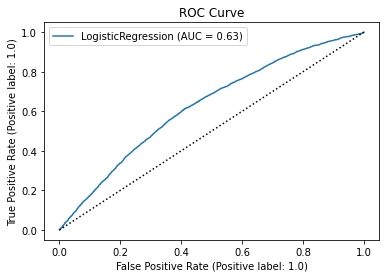

In [24]:
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:3]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
y_hat_valid = clf.predict(X_valid)
M = confusion_matrix(y_true=y_valid, y_pred=y_hat_valid)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'df:\n{df}')
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.5}')
RocCurveDisplay.from_estimator(clf, X_valid, y_valid)
plt.plot([0, 1], [0, 1], ':k') # add diagonal line
plt.title('ROC Curve')
plt.legend()
plt.show(block=False)

Next, let's add two more features `Stroke ` and `AlcoholDrinking`to our model: False-negative rate improved to 0.989.

df:
       0   1
0  29219  23
1   2706  31

TN: 29219, FP: 23, FN: 2706, TP: 31

TPR=0.0113, FPR=0.000787, FNR=0.98867


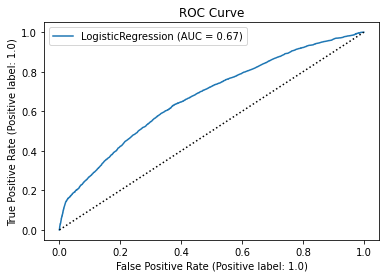

In [25]:
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:5]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
y_hat_valid = clf.predict(X_valid)
M = confusion_matrix(y_true=y_valid, y_pred=y_hat_valid)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'df:\n{df}')
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.5}')
RocCurveDisplay.from_estimator(clf, X_valid, y_valid)
plt.plot([0, 1], [0, 1], ':k') # add diagonal line
plt.title('ROC Curve')
plt.legend()
plt.show(block=False)

Lastly, let's run our model on all variables. We got the best ROC with the lowest false-negative of 0.885 among the three tries. So, let's <b>keep all variables</b> in our model.

df:
       0    1
0  28995  247
1   2421  316

TN: 28995, FP: 247, FN: 2421, TP: 316

TPR=0.115, FPR=0.00845, FNR=0.88455


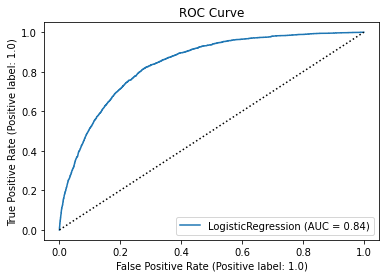

In [26]:
# set HeartDisease as y variable
y = data[:,0]
X = data[:,1:]
# split the dataset into train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=.5,random_state=0, stratify=y_tmp)

clf = linear_model.LogisticRegression(C=100, max_iter=5000)
clf.fit(X_train, y_train)
y_hat_valid = clf.predict(X_valid)
M = confusion_matrix(y_true=y_valid, y_pred=y_hat_valid)
# to include row and column labels, put matrix in DataFrame
df = pd.DataFrame(data=M) # or pd.DataFrame(data=M, index=['0', '1'], columns=['0', '1'])
print(f'df:\n{df}')
# peel off component counts from confusion matrix
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.5}')
RocCurveDisplay.from_estimator(clf, X_valid, y_valid)
plt.plot([0, 1], [0, 1], ':k') # add diagonal line
plt.title('ROC Curve')
plt.legend()
plt.show(block=False)

##### 2. How does our model perform?
Now, let's see the confusion matrix associated with our chosen model on the testing data set. While the overall score is relatively high (accuracy = 0.917 - part D.1), our false-negative rate is very high, with only 0.107 of the positive cases correctly predicted. This high rate is due to the dataset’s non-equal positive and negative heart diseases diagnosis samples. We had about 9% of individuals with heart disease in this dataset. It might help improve our model if it was balanced in the dataset.  

In [28]:
y = y_test
y_hat = clf.predict(X_test)
M = confusion_matrix(y_true=y, y_pred=y_hat)
df1 = pd.DataFrame(data=M)
print('df1:')
print(df1)
TN, FP, FN, TP = M.ravel() # .ravel() returns a vector from a matrix
print(f'\nTN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
print(f'\nTPR={TPR:.3}, FPR={FPR:.3}, FNR={FNR:.3}')

df1:
       0    1
0  28975  267
1   2446  292

TN: 28975, FP: 267, FN: 2446, TP: 292

TPR=0.107, FPR=0.00913, FNR=0.893


The coefficients obtained from the logistic regression model are as below. `Stroke`, `Sex`, `Race`, `GenHealth`, and `KidneyDisease` appear to be the most critical factors.

In [29]:
coefs = clf.coef_
cols = list(df_copy)
cols.remove('HeartDisease')
listcoef = coefs.tolist()
listcoef = listcoef[0]
table = pd.DataFrame()
table['Variables'] = cols
table['Coeficients'] = listcoef
print(table)

                         Variables  Coeficients
0                              BMI     0.008712
1                          Smoking     0.347089
2                  AlcoholDrinking    -0.237572
3                           Stroke     1.039184
4                   PhysicalHealth     0.001972
5                     MentalHealth     0.004165
6                      DiffWalking     0.237526
7                              Sex     0.713386
8                         Diabetic     0.469800
9                 PhysicalActivity     0.018122
10                       SleepTime    -0.028957
11                          Asthma     0.281968
12                   KidneyDisease     0.574205
13                      SkinCancer     0.114863
14  American Indian/Alaskan Native    -0.612518
15                           Asian    -1.051464
16                           Black    -0.901265
17                        Hispanic    -0.791954
18                           Other    -0.588563
19                           White    -0